<a href="https://colab.research.google.com/github/aryanasadianuoit/Adaptive-Graph-Based-Cohort-Creation-For-Deep-MutualLearning/blob/master/KDCopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

In [2]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


In [51]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dense(64, activation='relu',name="teacher_target_layer"))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Take a look at the model summary

Teacher.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               1048832   
_________________________________________________________________
teacher_target_layer (Dense) (None, 64)              

In [38]:
myCP = ModelCheckpoint(save_best_only=True,filepath='teacher.h5',monitor = 'val_acc')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split = 0.2,
         callbacks=[myCP])

Epoch 1/20
313/313 [==============================] - 3s 9ms/step - loss: 1.8089 - accuracy: 0.3393 - val_loss: 1.4214 - val_accuracy: 0.5014
Epoch 2/20
313/313 [==============================] - 3s 8ms/step - loss: 1.4270 - accuracy: 0.4933 - val_loss: 1.2151 - val_accuracy: 0.5774
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 1.2571 - accuracy: 0.5552 - val_loss: 1.1117 - val_accuracy: 0.6134
Epoch 4/20
313/313 [==============================] - 3s 8ms/step - loss: 1.1281 - accuracy: 0.6049 - val_loss: 1.0769 - val_accuracy: 0.6155
Epoch 5/20
313/313 [==============================] - 3s 8ms/step - loss: 1.0394 - accuracy: 0.6418 - val_loss: 1.0057 - val_accuracy: 0.6497
Epoch 6/20
313/313 [==============================] - 3s 8ms/step - loss: 0.9668 - accuracy: 0.6653 - val_loss: 0.9448 - val_accuracy: 0.6646
Epoch 7/20
313/313 [==============================] - 3s 8ms/step - loss: 0.8976 - accuracy: 0.6925 - val_loss: 0.9180 - val_accuracy: 0.6793
Epoch 

In [39]:
# Retrieve best model from saved
Teacher = load_model('teacher.h5')

# Evaluation with test set
Teacher.evaluate(x_test,y_test)

OSError: ignored

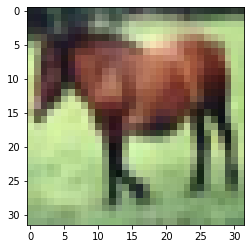

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

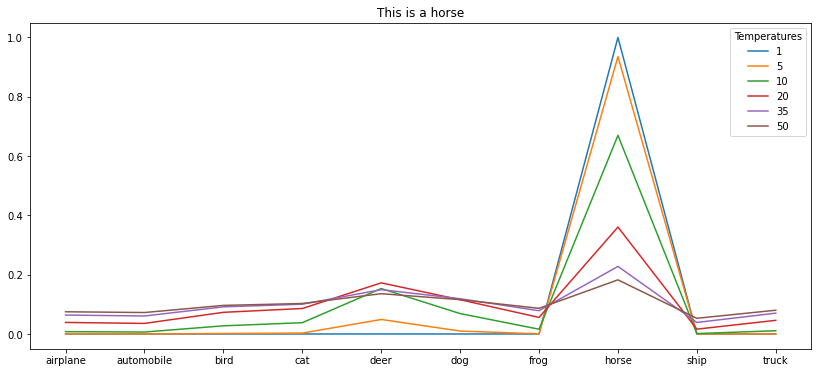

In [40]:
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)

logits_plot = []

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]										


# Choose the item to visualize temperature
item_idx = 7

item_image = x_train[item_idx]

plt.imshow(item_image)

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures:
  # Create temperature layer that produces logits with temperature
  T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
  
  # Create a softmax layer
  Softmax_layer = Softmax()(T_layer)
  # Add the teacher T_layer to the whole model
  Teacher_logits_soften = Model(Teacher.input,Softmax_layer)
                             
  # Append for plotting
  logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))
  
  plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
  sns.lineplot(class_names,logits_plot[i][0],legend="full")
  plt.title('This is a '+ class_names[y_train[item_idx][0]])
  plt.legend(Temperatures,title="Temperatures")

In [41]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [42]:
# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

In [43]:
Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
Student.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_24 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [44]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

In [45]:
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)
  
  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)

In [46]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])


In [47]:
myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 1s 4ms/step - loss: 6.2276 - accuracy: 0.2961 - val_loss: 5.3265 - val_accuracy: 0.3439
Epoch 2/50
333/333 [==============================] - 1s 4ms/step - loss: 5.6305 - accuracy: 0.3607 - val_loss: 5.2260 - val_accuracy: 0.3528
Epoch 3/50
333/333 [==============================] - 1s 4ms/step - loss: 5.4593 - accuracy: 0.3772 - val_loss: 5.0748 - val_accuracy: 0.3632
Epoch 4/50
333/333 [==============================] - 1s 4ms/step - loss: 5.3474 - accuracy: 0.3839 - val_loss: 4.9114 - val_accuracy: 0.3693
Epoch 5/50
333/333 [==============================] - 1s 4ms/step - loss: 5.2401 - accuracy: 0.3935 - val_loss: 4.8622 - val_accuracy: 0.3713
Epoch 6/50
333/333 [==============================] - 1s 4ms/step - loss: 5.1711 - accuracy: 0.3975 - val_loss: 4.8344 - val_accuracy: 0.3716
Epoch 7/50
333/333 [==============================] - 1s 4ms/step - loss: 5.0980 - accuracy: 0.4044 - val_loss: 5.0355 - val_accuracy: 0.3497
Epoch 

In [14]:
AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
AloneModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [48]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_acc')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 1s 4ms/step - loss: 1.7027 - accuracy: 0.3871 - val_loss: 1.7655 - val_accuracy: 0.3665
Epoch 2/50
333/333 [==============================] - 1s 3ms/step - loss: 1.6996 - accuracy: 0.3895 - val_loss: 1.8274 - val_accuracy: 0.3407
Epoch 3/50
333/333 [==============================] - 1s 3ms/step - loss: 1.7059 - accuracy: 0.3870 - val_loss: 1.7718 - val_accuracy: 0.3671
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 1.7011 - accuracy: 0.3903 - val_loss: 1.7686 - val_accuracy: 0.3663
Epoch 5/50
333/333 [==============================] - 1s 3ms/step - loss: 1.6995 - accuracy: 0.3891 - val_loss: 1.8169 - val_accuracy: 0.3517
Epoch 6/50
333/333 [==============================] - 1s 3ms/step - loss: 1.7005 - accuracy: 0.3884 - val_loss: 1.7845 - val_accuracy: 0.3608
Epoch 7/50
333/333 [==============================] - 1s 3ms/step - loss: 1.6987 - accuracy: 0.3909 - val_loss: 1.7838 - val_accuracy: 0.3591
Epoch 

In [49]:
small_student = Sequential() #a Must define the input shape in the first layer of the neural network
small_student.add(Flatten(input_shape=(32,32,3)))
small_student.add(Dense(64, activation='relu',name="target_dense_layer"))
small_student.add(Dense(10))
small_student.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3072)              0         
_________________________________________________________________
target_dense_layer (Dense)   (None, 64)                196672    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [69]:

# the output of a Dense layer in the teacher targeted for Knowledge distillation

intermediate_teacher_model = Model(Teacher.input, Teacher.get_layer("teacher_target_layer").output)

intermediate_teacher_model.summary()
y_train_internal = intermediate_teacher_model.predict(x_train)
y_test_internal = intermediate_teacher_model.predict(x_test)



print(y_train_internal)
#y_train_new_internal = to_categorical( y_train_internal, dtype='float32')
#y_test_new_internal = to_categorical(  y_test_internal, dtype='float32')



#y_train_new_internal_added = np.c_[to_categorical(y_train_new),y_train_internal]
#y_test_new_internal_added = np.c_[to_categorical(y_test_new),y_test_internal]

print(outer.shape)


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13_input (InputLayer) [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               104

In [71]:
small_student_internal_sub_model =  Model(small_student.input, small_student.get_layer("target_dense_layer").output)




In [74]:

# Predict and convert to sparse categorical matrix

#y_test_internal = Teacher_soften.predict(x_test).get_layer(name="teacher_target_layer").output

y_train_new = np.c_[to_categorical(y_train),y_train_internal]
y_test_new = np.c_[to_categorical(y_test),y_train_internal]





#KD Internal+regular loss function


small_student_logits = small_student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(small_student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(small_student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

small_student_softmax = Model(small_student.input,CombinedLayers)


def KD_complete_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)
  +keras.backend.sqrt(keras.backend.sum(keras.backend.square(intermediate_teacher_model.output - small_student_internal_sub_model.output), axis=-1))

  
  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)


NotImplementedError: ignored

In [30]:
#Standalone regular training

small_student.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

myCP = ModelCheckpoint(_best_only=True,filepath='small_student.h5',monitor = 'val_acc')

small_student.fit(x_train,y_train,epochs=20,validation_split=0.15,batch_size=128,callbacks=[myCP])


Epoch 1/20
333/333 [==============================] - 4s 12ms/step - loss: 2.5782 - accuracy: 0.0992 - val_loss: 2.3026 - val_accuracy: 0.1015
Epoch 2/20
333/333 [==============================] - 4s 12ms/step - loss: 2.3224 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.1015
Epoch 3/20
333/333 [==============================] - 4s 12ms/step - loss: 2.3243 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.0953
Epoch 4/20
333/333 [==============================] - 4s 12ms/step - loss: 2.3072 - accuracy: 0.0999 - val_loss: 2.3026 - val_accuracy: 0.0953
Epoch 5/20
333/333 [==============================] - 4s 12ms/step - loss: 2.3208 - accuracy: 0.1035 - val_loss: 2.3026 - val_accuracy: 0.1015
Epoch 6/20
333/333 [==============================] - 4s 12ms/step - loss: 2.3369 - accuracy: 0.0995 - val_loss: 2.3026 - val_accuracy: 0.1015
Epoch 7/20
333/333 [==============================] - 4s 12ms/step - loss: 2.3114 - accuracy: 0.0995 - val_loss: 2.3026 - val_accuracy: 0.1015

KeyboardInterrupt: ignored